<a href="https://colab.research.google.com/github/kondou-shouichi-hro/kondou-shouichi-hro.github.io/blob/master/shika_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像ファイルのアップロード

Googleにログインし、[https://drive.google.com/drive/u/0/my-drive](https://drive.google.com/drive/u/0/my-drive)からGoogle Driveにアクセスする。

以下の画像のように画像が入ったフォルダをドラッグアンドドロップし、アップロードする。フォルダ内にフォルダがある階層構造になっていても問題ない。

<img src="https://kondou-shouichi-hro.github.io/images/google-drive-upload.png" width=1000>

# Google Colaboratoryの準備

- Googleアカウントにログインする
- 「接続」ボタンをクリックしランタイムに接続する

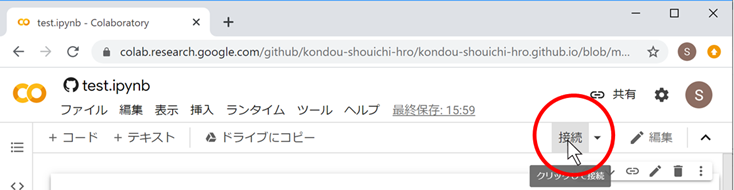
<br><br>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ライブラリのインストール

次のセルを実行する。数分～十数分の時間がかかる。

* Deep Learningライブラリのインストール
* 学習済み重みファイル、設定ファイルのダウンロード
* 学習済みモデルの読み込み

等が行われる。

以下の画像のようにセルの左上にあるボタンをクリックすると実行される。

<br>
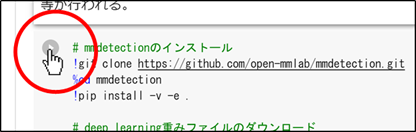
<br><br>

In [0]:
# mmdetectionのインストール
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements.txt
!pip install -v -e .
!pip install -U pillow

# deep learning重みファイルのダウンロード
!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=149DCYqaehEC5ZCDB5rCNvC3vsqew1cmL" > /dev/null;CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)" ;curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=149DCYqaehEC5ZCDB5rCNvC3vsqew1cmL" -o weight.pth

# deep learning設定ファイルのダウンロード
!wget https://raw.githubusercontent.com/kondou-shouichi-hro/kondou-shouichi-hro.github.io/master/shika_hiru_reppoints_moment_x101_dcn_fpn_2x_mt.py

# ライブラリのimport
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from pathlib import Path
from tqdm import tqdm

%cd ..

# 解析画像保存用フォルダ
!mkdir images

# モデルのロード
model = init_detector('./mmdetection/shika_hiru_reppoints_moment_x101_dcn_fpn_2x_mt.py', './mmdetection/weight.pth')

# Google Driveをマウント

アップロードした画像を読み込むために、以下の手順に従ってGoogle Driveをマウントする。（2～4は出ない場合もあるかもしれないです）

1. 「ドライブをマウント」をクリックする<br>
<img src="https://kondou-shouichi-hro.github.io/images/google-drive-mount1.png" width="300"><br>

2. 表示されたセルを実行する<br>
<img src="https://kondou-shouichi-hro.github.io/images/google-drive-mount2.png" width="600"><br>

3. 表示されたURLをクリックし、指示に従い認証コードを取得する。<br>
<img src="https://kondou-shouichi-hro.github.io/images/google-drive-mount3.png" width="600"><br>

4. 認証コードをフォームに入力しエンターキーを押す。<br>
<img src="https://kondou-shouichi-hro.github.io/images/google-drive-mount4.png" width="600"><br>


# 画像フォルダのパスのコピー

「drive/My Drive」フォルダにGoogle Driveの中身が表示されているので、画像が入っているフォルダを右クリックし「パスをコピー」をクリックする。

下のセルの

<img src="https://kondou-shouichi-hro.github.io/images/path-copy.png" width="300">

# 画像フォルダのパスを保存

画像のように下のコードブロックにパスを貼り付け実行する

<img src="https://kondou-shouichi-hro.github.io/images/path-paste.png"  width=600>

In [0]:
input_dir = 'ここにパスを張り付ける''

# シカ検出プログラムの実行

次のセルを実行する。1秒間に数枚くらいの速度。

In [245]:
import pandas as pd
from natsort import index_natsorted, order_by_index
import pandas.io.formats.excel
import openpyxl as xl
from openpyxl.styles.borders import Border
from openpyxl.styles.alignment import Alignment
from itertools import chain

output_dir = './output'
score_thr = 0.5
types = ['jpg', 'png', 'JPG']
output_excel = f'{output_dir}/{Path(input_dir).stem}.xlsx'

results = []
counts = []
image_names = []
folder_names = []

# Deep Learningによる検出

for name in tqdm(chain(*[Path(input_dir).rglob(f'*.{ext}') for ext in types])):
  result = inference_detector(model, str(name))
  count = sum(result[0][:, 4] > score_thr)
  relative_path = name.relative_to(Path(input_dir).parent)
  output_name = f'{output_dir}/{relative_path}'
  model.show_result(str(name), result, out_file=output_name,
                    bbox_color='red', text_color='red',
                    show=False, score_thr=score_thr)
  image_names.append(str(relative_path))
  folder_names.append(str(relative_path.parent))
  counts.append(count)
  results.append(result)



# 結果の集計
df1 = pd.DataFrame(data={'image_name': image_names,
                   'folder_name': folder_names,
                   'count': counts})

# df2 = df1.groupby('folder_name').sum()
df2 = df1.groupby('folder_name').agg({'count': ['sum', 'count', lambda x: x.ne(0).sum()]})
df2 = df2.reindex(index=order_by_index(df2.index, index_natsorted(df2.index)))

# エクセルファイルへ書き込み
with pd.ExcelWriter(output_excel) as writer:
  df2.to_excel(writer, sheet_name='合計', header=False)
  df1.to_excel(writer, sheet_name='詳細', index=False)
  dfdict = {'合計': df2, '詳細': df1}
  # ヘッダ
  writer.sheets['合計'].write(0, 0, 'フォルダ名')
  writer.sheets['合計'].write(0, 1, '合計検出頭数')
  writer.sheets['合計'].write(0, 2, '撮影枚数')
  writer.sheets['合計'].write(0, 3, '検出された枚数')

# フォント調整
wb = xl.load_workbook(filename=output_excel)
for ws in wb:
  for row in ws:
    for cell in row:
        ws[cell.coordinate].border = None
        ws[cell.coordinate].font = None
        ws[cell.coordinate].alignment = Alignment(horizontal='left')

  for col in ws.columns:
    max_length = 0
    column = col[0].column

    for cell in col:
        if len(str(cell.value)) > max_length:
            max_length = len(str(cell.value))

    adjusted_width = (max_length + 2)
    ws.column_dimensions[column].width = adjusted_width

wb.save(output_excel)







0it [00:00, ?it/s]





1it [00:00,  1.90it/s]


# 結果の確認・保存

outputフォルダに検出結果の画像と集計したエクセルファイルが出力される。

「drive/My Drive」にoutputフォルダをドラッグアンドドロップすると、google driveから画像をダウンロードできる。

<img src="https://kondou-shouichi-hro.github.io/images/kekka-hozon.png" width="300" />
